In [893]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spl
from numpy.random import multivariate_normal as mvn, normal as normal
from scipy.optimize import minimize

In [783]:
isinstance(5.3, float)

True

In [1005]:
class PeriodicKernel:
    def __init__(self, amplitude, P, length_scale_periodic):
        self.amplitude = amplitude
        self.length_scale_periodic = length_scale_periodic
        self.P = P
        
        self.kernel = None
        self.loglikelihood = None
        self.x1 = None
        self.x2 = None
        self.y = None
        
    def compute_kernel(self, x1, x2, y_err=None, jitter=1e-10):
        self.x1 = x1
        self.x2 = x2
        
        tau = np.subtract.outer(x1, x2)  # pairwise differences
        
        self.kernel = (self.amplitude**2) * np.exp(
            -2*(
                (np.sin(np.pi*tau/self.P)**2) / (self.length_scale_periodic**2)
            )
        )
        
        if y_err is not None:
            self.kernel += np.diag(y_err)
        
        np.fill_diagonal(self.kernel, self.kernel.diagonal() + jitter)
        
        return self
    
    def compute_loglikelihood(self, y):
        self.y = y
        
        factor, flag = spl.cho_factor(self.kernel)
        lodget = 2*np.sum(np.log(np.diag(factor)))
        gof = np.dot(y, spl.cho_solve((factor, flag), y))
        self.loglikelihood = -0.5*(gof + lodget + len(y)*np.log(2*np.pi))
        
        return self
    
    def clone(self):
        return PeriodicKernel(self.amplitude, self.P, self.length_scale_periodic)
    
    def compute_posterior(self, x_test):
        assert self.kernel is not None, "Kernel has not been computed. Please run compute_kernel first."
        assert self.loglikelihood is not None, "Loglikelihood has not been computed. Please run compute_loglikelihood first."
        
        temp_kernel = self.clone()
        
        K_test_train = temp_kernel.compute_kernel(x_test, self.x1).kernel  # Kernel between test and train points
        K_test_test = temp_kernel.compute_kernel(x_test, x_test).kernel  # Kernel for the test points
        
        factor, flag = spl.cho_factor(self.kernel)  # Cholesky decomposition of the training kernel matrix
        K_inv_y = spl.cho_solve((factor, flag), self.y)  # Solve self.kernel^-1 * y_train
        
        mu_post = np.dot(K_test_train, K_inv_y)  # Compute the posterior mean
        
        v = spl.cho_solve((factor, flag), K_test_train.T)  # Solve self.kernel^-1 * K_test_train.T
        cov_post = K_test_test - np.dot(K_test_train, v)  # Compute the posterior covariance
        
        return mu_post, cov_post
    
    def fit(self, x, y, y_err, bounds=None, jitter=1e-10):
        self.compute_kernel(x, x, y_err, jitter).compute_loglikelihood(y)
        
        if bounds is None:
            bounds = [[(1e-4, None), (1e-4, None), (1e-4, None)]]
        
        def objective(theta):
            return -PeriodicKernel(*theta).compute_kernel(x, x, y_err, jitter).compute_loglikelihood(y).loglikelihood
        
        result = minimize(
            objective, 
            np.array([self.amplitude, self.P, self.length_scale_periodic]), 
            method='L-BFGS-B', 
            bounds=bounds
        )
        
        return result

class MultiQuasiPeriodicKernel:
    def __init__(self, amplitudes, Ps, length_scale_periodics, length_scale_exp):
        assert len(amplitudes) == len(Ps) == len(length_scale_periodics)
        assert isinstance(length_scale_exp, float)
        
        self.amplitudes = amplitudes
        self.Ps = Ps
        self.length_scale_periodics = length_scale_periodics
        self.length_scale_exp= length_scale_exp
        self.periodics = len(amplitudes)
        
        self.kernel = None
        self.loglikelihood = None
        self.x1 = None
        self.x2 = None
        self.y = None
        
    def compute_kernel(self, x1, x2, y_err=None, jitter=1e-10):
        self.x1 = x1
        self.x2 = x2
        
        tau = np.subtract.outer(x1, x2)  # pairwise differences
        
        self.kernel = (self.amplitudes[0]**2) * np.exp(
            -(
                ((tau/self.length_scale_exp)**2)/2 +
                (np.sin(np.pi*tau/self.Ps[0])**2) / (self.length_scale_periodics[0]**2)
            )
        )
        
        for i in range(1, self.periodics):
            additional_kernel = (self.amplitudes[i]**2) * np.exp(
                -(
                    (np.sin(np.pi*tau/self.Ps[i])**2) / (self.length_scale_periodics[i]**2)
                )
            )
            self.kernel += additional_kernel
        
        if y_err is not None:
            self.kernel += np.diag(y_err)
        
        np.fill_diagonal(self.kernel, self.kernel.diagonal() + jitter)
        
        return self
    
    def compute_loglikelihood(self, y):
        self.y = y
        
        factor, flag = spl.cho_factor(self.kernel)
        lodget = 2*np.sum(np.log(np.diag(factor)))
        gof = np.dot(y, spl.cho_solve((factor, flag), y))
        self.loglikelihood = -0.5*(gof + lodget + len(y)*np.log(2*np.pi))
        
        return self
    
    def clone(self):
        return MultiQuasiPeriodicKernel(self.amplitudes, self.Ps, self.length_scale_periodics, self.length_scale_exp)
    
    def compute_posterior(self, x_test):
        assert self.kernel is not None, "Kernel has not been computed. Please run compute_kernel first."
        assert self.loglikelihood is not None, "Loglikelihood has not been computed. Please run compute_loglikelihood first."
        
        temp_kernel = self.clone()
        
        K_test_train = temp_kernel.compute_kernel(x_test, self.x1).kernel  # Kernel between test and train points
        K_test_test = temp_kernel.compute_kernel(x_test, x_test).kernel  # Kernel for the test points
        
        factor, flag = spl.cho_factor(self.kernel)  # Cholesky decomposition of the training kernel matrix
        K_inv_y = spl.cho_solve((factor, flag), self.y)  # Solve self.kernel^-1 * y_train
        
        mu_post = np.dot(K_test_train, K_inv_y)  # Compute the posterior mean
        
        v = spl.cho_solve((factor, flag), K_test_train.T)  # Solve self.kernel^-1 * K_test_train.T
        cov_post = K_test_test - np.dot(K_test_train, v)  # Compute the posterior covariance
        
        return mu_post, cov_post
    
    def fit(self, x, y, y_err, bounds=None, jitter=1e-10):
        self.compute_kernel(x, x, y_err, jitter).compute_loglikelihood(y)
        
        if bounds is None:
            bounds = [[(1e-4, None) for _ in range(3 * self.periodics + 1)]]
        
        def objective(theta):
            amplitudes = theta[0:self.periodics]
            Ps = theta[self.periodics:self.periodics+2]
            length_scale_periodics = theta[self.periodics+2:self.periodics+4]
            length_scale_exp = theta[-1]
            
            return -MultiQuasiPeriodicKernel(amplitudes, Ps, length_scale_periodics, length_scale_exp).compute_kernel(x, x, y_err, jitter).compute_loglikelihood(y).loglikelihood
        
        result = minimize(
            objective, 
            np.array([*self.amplitudes, *self.Ps, *self.length_scale_periodics, self.length_scale_exp]), 
            method='L-BFGS-B', 
            bounds=bounds
        )
        
        return result

class QuasiPeriodicKernel:
    def __init__(self, amplitude, P, length_scale_periodic, length_scale_exp):
        self.amplitude = amplitude
        self.length_scale_exp = length_scale_exp
        self.length_scale_periodic = length_scale_periodic
        self.P = P
        
        self.kernel = None
        self.loglikelihood = None
        self.x1 = None
        self.x2 = None
        self.y = None
        
    def compute_kernel(self, x1, x2, y_err=None, jitter=1e-10):
        self.x1 = x1
        self.x2 = x2
        
        tau = np.subtract.outer(x1, x2)  # pairwise differences
        
        self.kernel = (self.amplitude**2) * np.exp(
            -(
                ((tau/self.length_scale_exp)**2)/2 +
                (np.sin(np.pi*tau/self.P)**2) / (self.length_scale_periodic**2)
            )
        )
        
        if y_err is not None:
            self.kernel += np.diag(y_err)
        
        np.fill_diagonal(self.kernel, self.kernel.diagonal() + jitter)
        
        return self
    
    def compute_loglikelihood(self, y):
        self.y = y
        
        factor, flag = spl.cho_factor(self.kernel)
        lodget = 2*np.sum(np.log(np.diag(factor)))
        gof = np.dot(y, spl.cho_solve((factor, flag), y))
        self.loglikelihood = -0.5*(gof + lodget + len(y)*np.log(2*np.pi))
        
        return self
    
    def clone(self):
        return QuasiPeriodicKernel(self.amplitude, self.P, self.length_scale_periodic, self.length_scale_exp)
    
    def compute_posterior(self, x_test):
        assert self.kernel is not None, "Kernel has not been computed. Please run compute_kernel first."
        assert self.loglikelihood is not None, "Loglikelihood has not been computed. Please run compute_loglikelihood first."
        
        temp_kernel = self.clone()
        
        K_test_train = temp_kernel.compute_kernel(x_test, self.x1).kernel  # Kernel between test and train points
        K_test_test = temp_kernel.compute_kernel(x_test, x_test).kernel  # Kernel for the test points
        
        factor, flag = spl.cho_factor(self.kernel)  # Cholesky decomposition of the training kernel matrix
        K_inv_y = spl.cho_solve((factor, flag), self.y)  # Solve self.kernel^-1 * y_train
        
        mu_post = np.dot(K_test_train, K_inv_y)  # Compute the posterior mean
        
        v = spl.cho_solve((factor, flag), K_test_train.T)  # Solve self.kernel^-1 * K_test_train.T
        cov_post = K_test_test - np.dot(K_test_train, v)  # Compute the posterior covariance
        
        return mu_post, cov_post
    
    def fit(self, x, y, y_err, bounds=None, jitter=1e-10):
        self.compute_kernel(x, x, y_err, jitter).compute_loglikelihood(y)
        
        if bounds is None:
            bounds = [[(1e-4, None), (1e-4, None), (1e-4, None), (1e-4, None)]]
        
        def objective(theta):
            return -QuasiPeriodicKernel(*theta).compute_kernel(x, x, y_err, jitter).compute_loglikelihood(y).loglikelihood
        
        result = minimize(
            objective, 
            np.array([self.amplitude, self.P, self.length_scale_periodic, self.length_scale_exp]), 
            method='L-BFGS-B', 
            bounds=bounds
        )
        
        return result
        


class StellarActivityGP:
    def __init__(self, x, y, y_err=None):
        self. x = x
        self.y = y if len(y.shape) > 1 else y.reshape(-1, 1)
        
        if y_err is None:
            y_err = np.zeros_like(y)
        
        self.y_err = y_err if len(y_err.shape) > 1 else y_err.reshape(-1, 1)
        
        self.y_dim = y.shape[1] if len(y.shape) > 1 else 1
        
    def fit(self, amplitudes: list, P, length_scale_periodic, length_scale_exp, bounds=None, jitter=1e-10):
        assert len(amplitudes) == self.y_dim, "Number of amplitudes must match the number of dimensions in y"
        
        if bounds is None:
            bounds = [(1e-4, None) for _ in range(self.y_dim)] + [(1e-4, None), (1e-4, None), (1e-4, None)]
        
        def objective(theta):
            loglikelihood = 0
            
            amplitudes = theta[:-3]
            P = theta[-3]
            length_scale_periodic = theta[-2]
            length_scale_exp = theta[-1]
            
            kernels = [
                QuasiPeriodicKernel(amplitude, P, length_scale_periodic, length_scale_exp)
                for amplitude in amplitudes
            ]
            
            for i, kernel in enumerate(kernels):
                loglikelihood += (
                    kernel.compute_kernel(self.x, self.x, self.y_err[:, i], jitter).compute_loglikelihood(self.y[:, i]).loglikelihood
                )
            
            return -loglikelihood
        
        result = minimize(
            objective, 
            np.array([*amplitudes, P, length_scale_periodic, length_scale_exp]), 
            method='L-BFGS-B', 
            bounds=bounds
        )
        
        return result
    
class StellarAndPlanetGP:
    def __init__(self, x, y, y_err=None, num_planets=1):
        self. x = x
        self.y = y if len(y.shape) > 1 else y.reshape(-1, 1)
        
        if y_err is None:
            y_err = np.zeros_like(y)
        
        self.y_err = y_err if len(y_err.shape) > 1 else y_err.reshape(-1, 1)
        
        self.y_dim = y.shape[1] if len(y.shape) > 1 else 1
        
        self.num_planets = num_planets
        self.params_keys = [
            'stellar_amp', 'fwhm_amp', 'bis_amp', 'stellar_P', 'stellar_lsp', 'stellar_lse',
            *[f'p{i+1}_amp' for i in range(self.num_planets)],
            *[f'p{i+1}_P' for i in range(self.num_planets)],
            *[f'p{i+1}_lsp' for i in range(self.num_planets)],
        ]
        
        self.kernels = None
        self.model_params = {}
        
    def fit(self, initial_theta=None, bounds=None, jitter=1e-10):
        if initial_theta is None:
            initial_theta = {key: np.random.normal(1, 0.01) for key in self.params_keys}
        else:
            initial_theta = {
                key: initial_theta[key] if key in initial_theta.keys() else np.random.normal(1, 0.01) for key in self.params_keys
            }
            
        if bounds is None:
            bounds = {key: (1e-4, None) for key in initial_theta.keys()}
        else:
            bounds = {key: bounds[key] if key in bounds.keys() else (1e-4, None) for key in initial_theta.keys() }
            
        assert set(initial_theta.keys()).issubset(set(self.params_keys))
        
        print(initial_theta)
        print(bounds)
        
        def objective(theta):
            theta = {key: value for key, value in zip(initial_theta.keys(), theta)}
            
            stellar_amp = theta['stellar_amp']
            fwhm_amp = theta['fwhm_amp']
            bis_amp = theta['bis_amp']
            
            stellar_P = theta['stellar_P']
            stellar_lsp = theta['stellar_lsp']
            stellar_lse = theta['stellar_lse']
            
            planet_amps = [theta[f'p{i+1}_amp'] for i in range(self.num_planets)]
            planet_Ps = [theta[f'p{i+1}_P'] for i in range(self.num_planets)]
            planet_lsps = [theta[f'p{i+1}_lsp'] for i in range(self.num_planets)]
            
            loglikelihood = 0
            
            self.kernels = [
                MultiQuasiPeriodicKernel(
                    [stellar_amp, *planet_amps], 
                    [stellar_P, *planet_Ps], 
                    [stellar_lsp, *planet_lsps], 
                    stellar_lse
                ),
                QuasiPeriodicKernel(fwhm_amp, stellar_P, stellar_lsp, stellar_lse),
                QuasiPeriodicKernel(bis_amp, stellar_P, stellar_lsp, stellar_lse),
            ]
            
            for i, kernel in enumerate(self.kernels):
                loglikelihood += (
                    kernel.compute_kernel(self.x, self.x, self.y_err[:, i], jitter).compute_loglikelihood(self.y[:, i]).loglikelihood
                )
            
            return -loglikelihood
        
        result = minimize(
            objective, 
            np.array([*initial_theta.values()]), 
            method='L-BFGS-B', 
            bounds=bounds.values()
        )
        
        self.model_params = {key: value for key, value in zip(self.params_keys, result.x)}
        return result

    

# Now lets implement it onto our own data

In [968]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

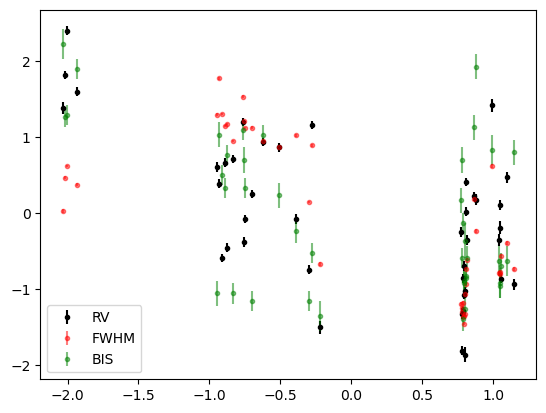

In [1023]:
data = pd.read_csv(
    '../../data/ex2_RVs.txt',
    sep=',',
    header=None,
    names=['time', 'radial_velocity', 'radial_velocity_uncertainty', 'FWHM_CCF',
           'FWHM_CCF_uncertainty', 'BIS', 'BIS_uncertainty', 'instrument'],
    skiprows=8,
)

data = data[~data['instrument'].isin(['INST1'])]

time_scaler = StandardScaler()
rv_scaler = StandardScaler()
fwhm_scaler = StandardScaler()
bis_scaler = StandardScaler()
y_scalers = [rv_scaler, fwhm_scaler, bis_scaler]

time = data['time'].values
rv = data['radial_velocity'].values
rv_err = data['radial_velocity_uncertainty'].values
fwhm = data['FWHM_CCF'].values
fwhm_err = data['FWHM_CCF_uncertainty'].values
bis = data['BIS'].values
bis_err = data['BIS_uncertainty'].values

time = time_scaler.fit_transform(time.reshape(-1, 1)).ravel()
rv = rv_scaler.fit_transform(rv.reshape(-1, 1)).ravel()
rv_err = (rv_err / rv_scaler.scale_).ravel()
fwhm = fwhm_scaler.fit_transform(fwhm.reshape(-1, 1)).ravel()
fwhm_err = (fwhm_err / fwhm_scaler.scale_).ravel()
bis = bis_scaler.fit_transform(bis.reshape(-1, 1)).ravel()
bis_err = (bis_err / bis_scaler.scale_).ravel()


y = np.vstack([rv, fwhm, bis]).T
y_err = np.vstack([rv_err, fwhm_err, bis_err]).T

plt.errorbar(time, y[:, 0], yerr=y_err[:, 0], fmt='k.', label='RV')
plt.errorbar(time, y[:, 1], yerr=y_err[:, 1], fmt='r.', label='FWHM', alpha=0.5)
plt.errorbar(time, y[:, 2], yerr=y_err[:, 2], fmt='g.', label='BIS', alpha=0.5)
plt.legend()

In [1028]:
p_lower, p_upper = [21, 41] / time_scaler.scale_
p_lower, p_upper

(0.07454656358118683, 0.14554329080136474)

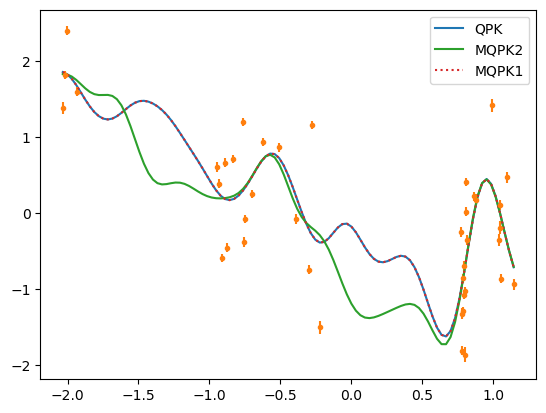

In [1066]:
np.random.seed(42)
x = np.linspace(time.min(), time.max(), 101)

init = normal(1, 0.1, 4)
mu_post, cov_post = QuasiPeriodicKernel(
    *init
).compute_kernel(
    time, time, rv_err
).compute_loglikelihood(
    rv
).compute_posterior(x)
plt.plot(x, mu_post, label='QPK')

mu_post, cov_post = MultiQuasiPeriodicKernel(
    normal(1.0, 0.1, 2), normal(1, 0.1, 2), normal(1, 0.1, 2), normal(1, 0.1)
).compute_kernel(
    time, time, rv_err, jitter=1e-3
).compute_loglikelihood(
     rv
).compute_posterior(x)

plt.errorbar(time, rv, rv_err, fmt='.')
plt.plot(x, mu_post, label='MQPK2')

mu_post, cov_post = MultiQuasiPeriodicKernel(
    [init[0]], [init[1]],[init[2]],init[3]
).compute_kernel(
    time, time, rv_err
).compute_loglikelihood(
     rv
).compute_posterior(x)
plt.plot(x, mu_post, label='MQPK1', linestyle=':')
plt.legend()

In [1030]:
gp = StellarActivityGP(time, y, y_err)
result = gp.fit(
    [1.0, 1.0, 1.0], 1.0, 1.0, 1.0, 
    bounds=[(1e-4, None), (1e-4, None), (1e-4, None), (p_lower, p_upper), (1e-4, None), (1e-4, None)]
)
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 115.88091724891646
        x: [ 1.408e+00  6.875e-01  1.011e+00  1.221e-01  6.529e-01
             5.061e-01]
      nit: 54
      jac: [-4.724e-03  2.760e-03 -4.022e-04  1.236e+00  3.872e-03
            -4.624e-03]
     nfev: 511
     njev: 73
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [1032]:
(result.x[3] * time_scaler.scale_)

array([34.38899326])

-65.59250833032391
-8.988947091643784
-41.299461826948765


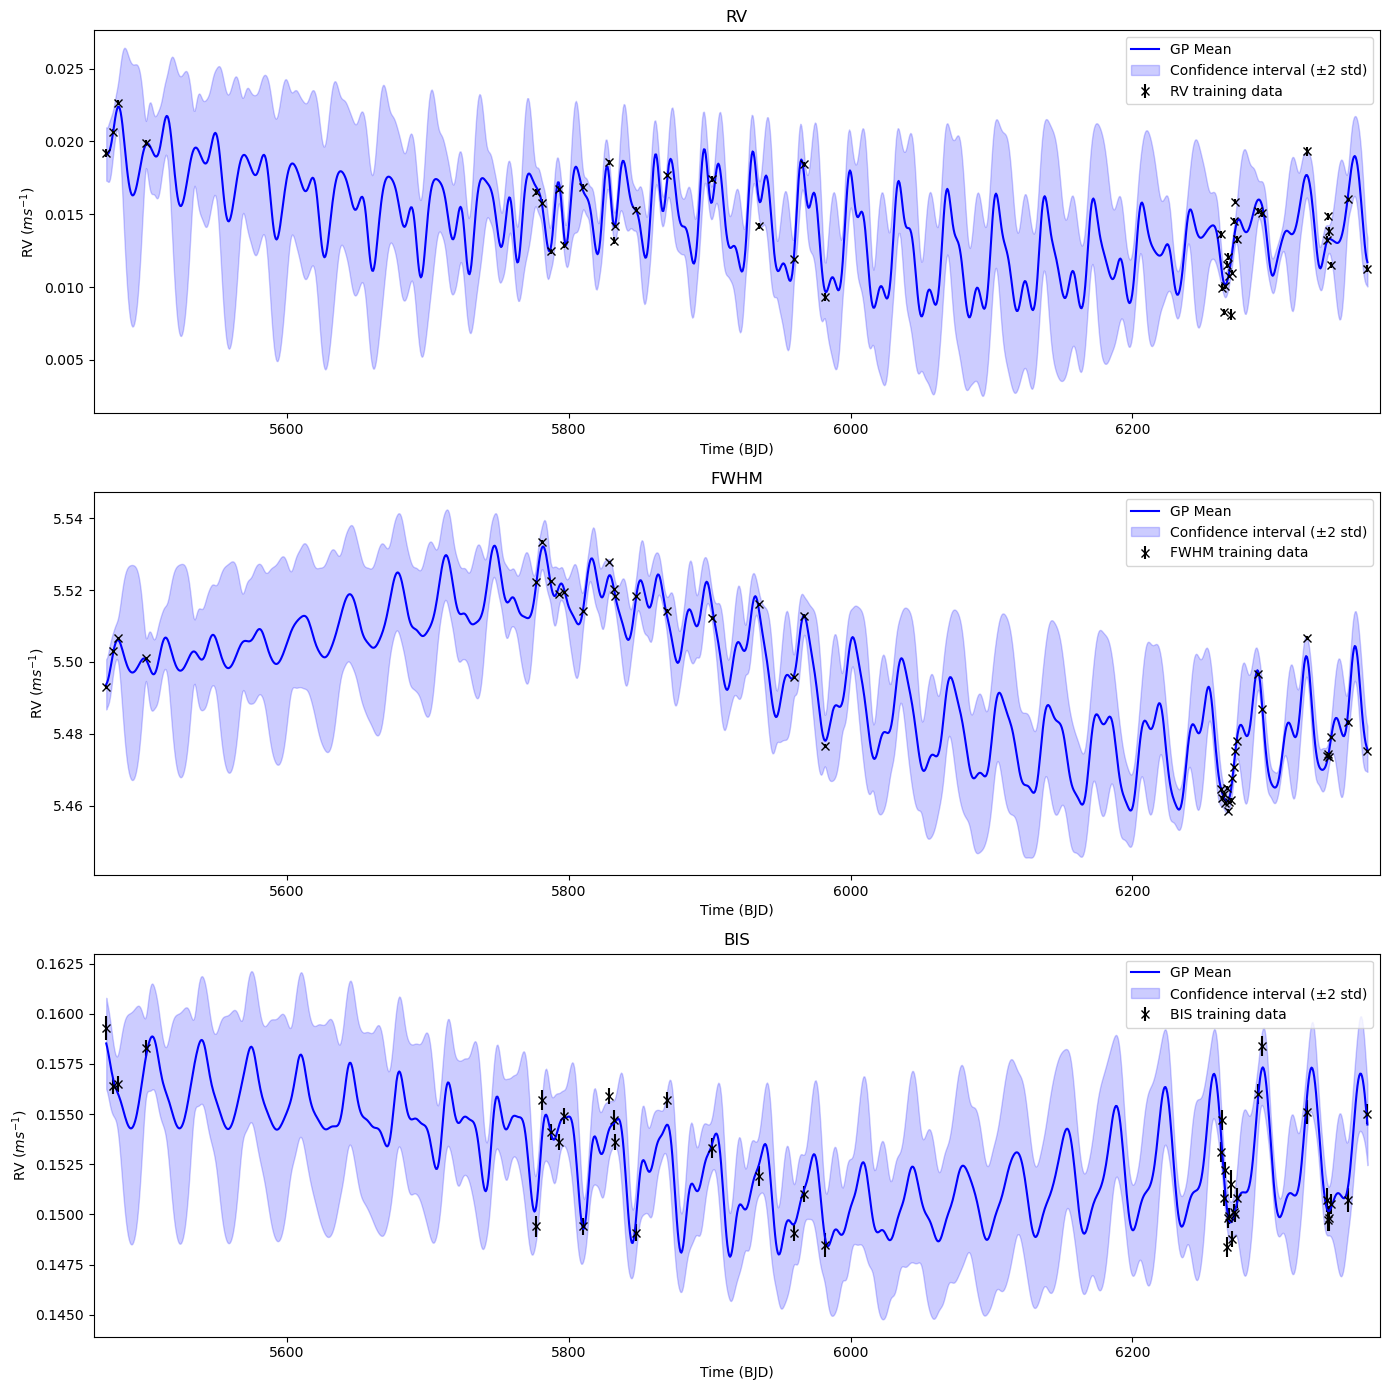

In [1033]:
# Extract the optimized parameters
optimized_theta = result.x
optimized_amplitudes = optimized_theta[:-3]
optimized_P = optimized_theta[-3]
optimized_length_scale_periodic = optimized_theta[-2]
optimized_length_scale_exp = optimized_theta[-1]

kernels = [
    QuasiPeriodicKernel(amp, optimized_P, optimized_length_scale_periodic, optimized_length_scale_exp)
    for amp in optimized_amplitudes
]

t_linspace = np.linspace(time.min(), time.max(), 1400)

posteriors = []

for i, kernel in enumerate(kernels):
    kernel.compute_kernel(time, time, y_err[:, i]).compute_loglikelihood(y[:, i])
    print(kernel.loglikelihood)
    mu_post, cov_post = kernel.compute_posterior(t_linspace)
    posteriors.append((mu_post, cov_post))

# Plot the results
plt.figure(figsize=(14, 14))

titles = ['RV', 'FWHM', 'BIS']
y_label = 'RV ($m s^{-1}$)'
x_label = 'Time (BJD)'

for i, (mu_post, cov_post) in enumerate(posteriors):
    std_post = np.sqrt(np.diag(cov_post))
    plt.subplot(3, 1, i+1)

    plt.errorbar(
        time_scaler.inverse_transform(time.reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform(y[:, i].reshape(-1, 1)).ravel(), 
        yerr=y_err[:, i] * y_scalers[i].scale_, 
        fmt='kx', label=f'{titles[i]} training data'
    )

    plt.plot(
        time_scaler.inverse_transform(t_linspace.reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform(mu_post.reshape(-1, 1)), 
        'b', label=f'GP Mean'
    )

    plt.fill_between(
        time_scaler.inverse_transform(t_linspace.reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform((mu_post - 2*std_post).reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform((mu_post + 2*std_post).reshape(-1, 1)).ravel(), 
        color='blue', alpha=0.2, label='Confidence interval (±2 std)'
    )
    
    plt.margins(x=0.01)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(titles[i])

plt.tight_layout()
plt.savefig('./sandbox_fig1.png')
plt.show()

In [1060]:
gp = StellarAndPlanetGP(time, y, y_err, num_planets=2)
# print(gp.params_keys)
result = gp.fit(
    bounds={'stellar_P': [21, 41] / time_scaler.scale_, 'p1_P': [0, 100] / time_scaler.scale_}
)
result

{'stellar_amp': 0.9970830625020672, 'fwhm_amp': 0.993982933877706, 'bis_amp': 1.0185227818450895, 'stellar_P': 0.9998650277526206, 'stellar_lsp': 0.989422890710441, 'stellar_lse': 1.0082254491210318, 'p1_amp': 0.9877915635002897, 'p2_amp': 1.0020886359500476, 'p1_P': 0.9804032987612022, 'p2_P': 0.9867181395110157, 'p1_lsp': 1.0019686123586913, 'p2_lsp': 1.0073846657999541}
{'stellar_amp': (0.0001, None), 'fwhm_amp': (0.0001, None), 'bis_amp': (0.0001, None), 'stellar_P': array([0.07454656, 0.14554329]), 'stellar_lsp': (0.0001, None), 'stellar_lse': (0.0001, None), 'p1_amp': (0.0001, None), 'p2_amp': (0.0001, None), 'p1_P': array([0.        , 0.35498364]), 'p2_P': (0.0001, None), 'p1_lsp': (0.0001, None), 'p2_lsp': (0.0001, None)}


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 108.79467004949637
        x: [ 1.259e+00  7.729e-01  1.084e+00  1.233e-01  7.625e-01
             7.232e-01  1.000e-04  7.034e-01  3.550e-01  1.535e+00
             8.317e-01  2.402e-01]
      nit: 230
      jac: [ 1.299e-02 -2.586e-02 -1.559e-02  6.879e-02 -3.189e-03
             6.283e-02  1.245e-03 -1.203e-02 -1.990e-05  1.459e-02
            -1.421e-05 -4.823e-02]
     nfev: 3640
     njev: 280
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>

In [1061]:
gp.model_params

{'stellar_amp': 1.2588610982223247,
 'fwhm_amp': 0.7729072397915381,
 'bis_amp': 1.0838413735966788,
 'stellar_P': 0.12326958771670954,
 'stellar_lsp': 0.7624971998412678,
 'stellar_lse': 0.7232424847228862,
 'p1_amp': 0.0001,
 'p2_amp': 0.703434254951738,
 'p1_P': 0.3549828019060817,
 'p2_P': 1.5352426302567161,
 'p1_lsp': 0.8317253606439982,
 'p2_lsp': 0.24021780957081776}

In [1063]:
gp.model_params['stellar_P'] * time_scaler.scale_, gp.model_params['p1_P'] * time_scaler.scale_, gp.model_params['p2_P'] * time_scaler.scale_

(array([34.72542821]), array([99.999765]), array([432.48264825]))

-61.447269326284726
-7.87672271226657
-39.47067801046281


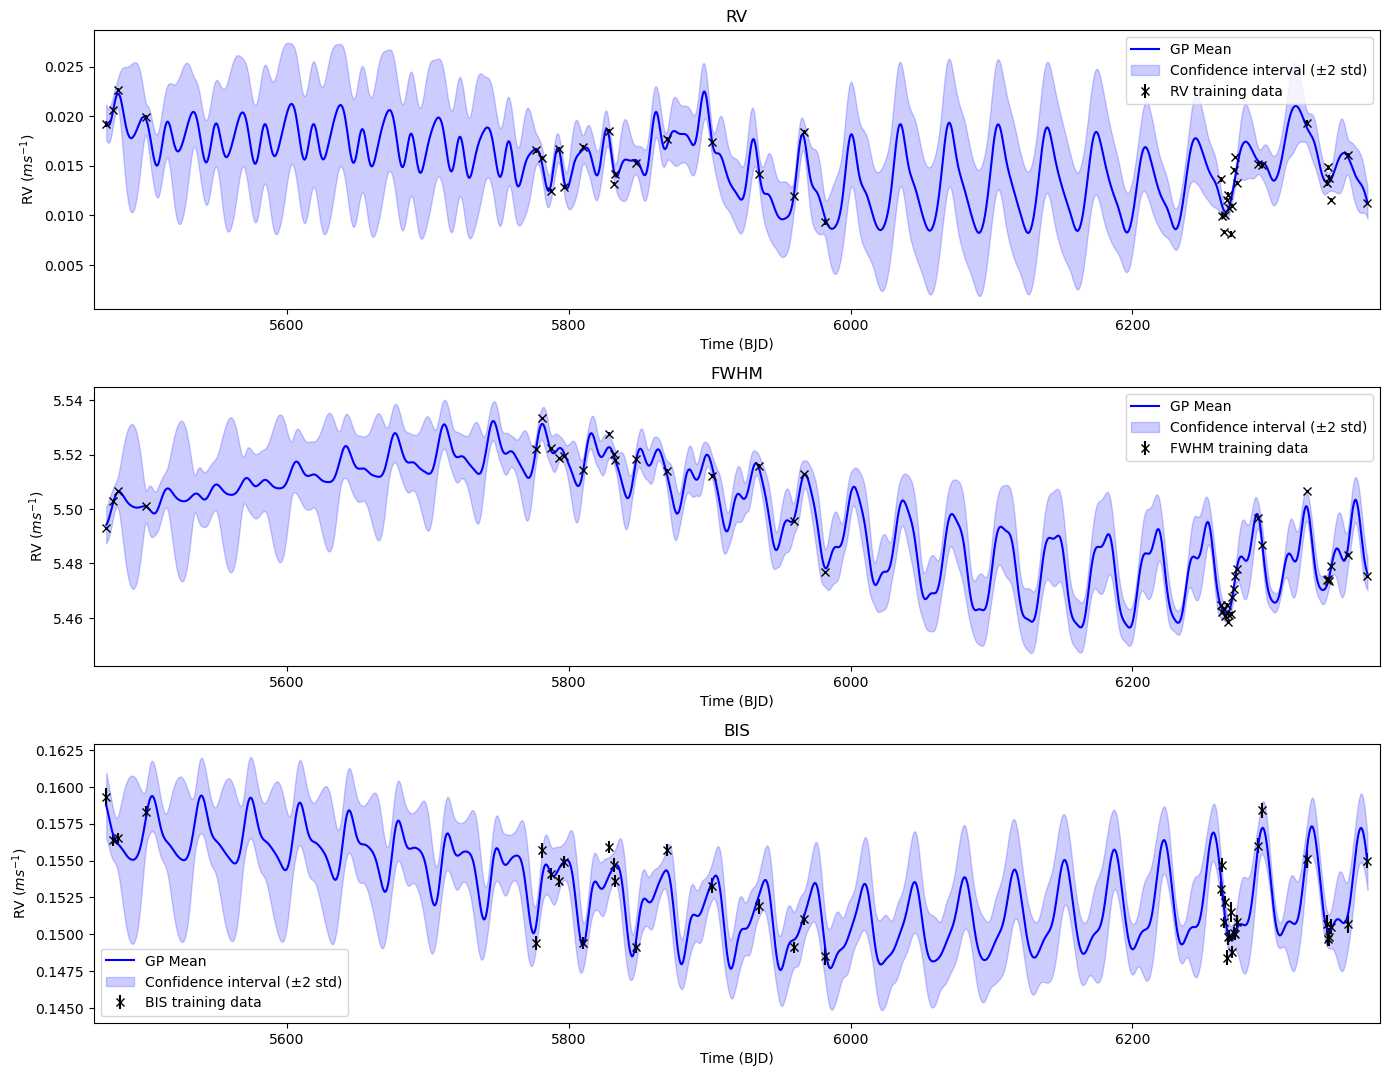

In [1064]:
# Extract the optimized parameters
# optimized_theta = result.x
# optimized_amplitudes = optimized_theta[:-3]
# optimized_P = optimized_theta[-3]
# optimized_length_scale_periodic = optimized_theta[-2]
# optimized_length_scale_exp = optimized_theta[-1]

kernels = gp.kernels

t_linspace = np.linspace(time.min(), time.max(), 1400)

posteriors = []

for i, kernel in enumerate(kernels):
    kernel.compute_kernel(time, time, y_err[:, i]).compute_loglikelihood(y[:, i])
    print(kernel.loglikelihood)
    mu_post, cov_post = kernel.compute_posterior(t_linspace)
    posteriors.append((mu_post, cov_post))

# Plot the results
plt.figure(figsize=(14, 14))

titles = ['RV', 'FWHM', 'BIS']
y_label = 'RV ($m s^{-1}$)'
x_label = 'Time (BJD)'

for i, (mu_post, cov_post) in enumerate(posteriors):
    std_post = np.sqrt(np.diag(cov_post))
    plt.subplot(4, 1, i+1)

    plt.errorbar(
        time_scaler.inverse_transform(time.reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform(y[:, i].reshape(-1, 1)).ravel(), 
        yerr=y_err[:, i] * y_scalers[i].scale_, 
        fmt='kx', label=f'{titles[i]} training data'
    )

    plt.plot(
        time_scaler.inverse_transform(t_linspace.reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform(mu_post.reshape(-1, 1)), 
        'b', label=f'GP Mean'
    )

    plt.fill_between(
        time_scaler.inverse_transform(t_linspace.reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform((mu_post - 2*std_post).reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform((mu_post + 2*std_post).reshape(-1, 1)).ravel(), 
        color='blue', alpha=0.2, label='Confidence interval (±2 std)'
    )
    
    plt.margins(x=0.01)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(titles[i])


plt.tight_layout()
# plt.savefig('./sandbox_fig2.png')
plt.show()

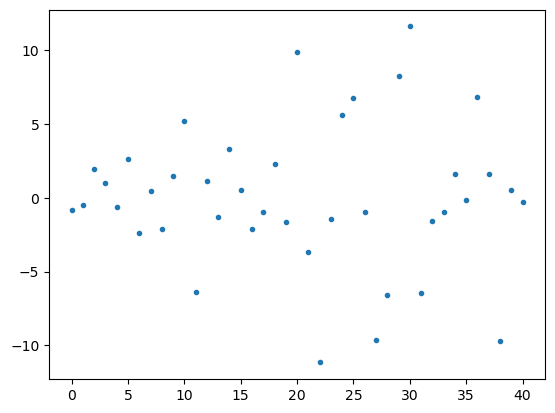

In [1065]:
kernel = gp.kernels[0]
kernel.compute_kernel(time, time, rv_err).compute_loglikelihood(rv)
mu_post, cov_post = kernel.compute_posterior(time)
residuals = rv - mu_post

plt.plot(residuals / rv_err, '.')

In [1050]:
posteriors[0][0]

(1400,)

<ErrorbarContainer object of 3 artists>

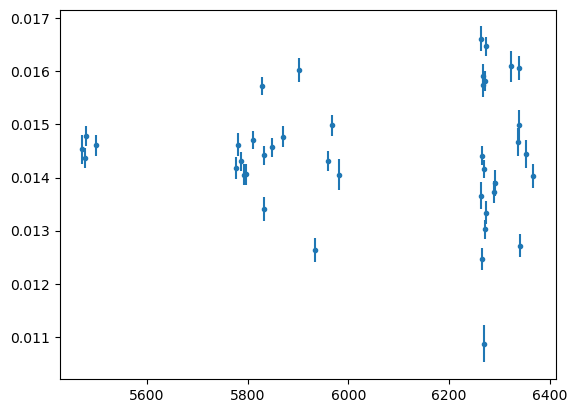

In [680]:
corrected_rv = rv - mu_post
plt.errorbar(
    time_scaler.inverse_transform(time.reshape(-1, 1)).ravel(), 
    rv_scaler.inverse_transform(corrected_rv.reshape(-1, 1)).ravel(), 
    rv_err * rv_scaler.scale_, 
    fmt='.', label=f'Training data y'
)

In [757]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

class KeplerianOrbitModel:
    def __init__(self, time, rv, rv_err):
        self.time = time
        self.rv = rv
        self.rv_err = rv_err
        
        self.P = None  # period
        self.T0 = None  # time of periastron passage
        self.e = None  # eccentricity
        self.w = None  # argument of periastron
        self.K = None  # radial velocity semi-amplitude
        self.gamma = None  # systemic velocity
    
    def _compute_mean_anomaly(self, t):
        """Compute the mean anomaly M given a time t"""
        return (2 * np.pi / self.P) * (t - self.T0)
    
    def _solve_keplers_equation(self, M, e, tol=1e-6):
        """Solve Kepler's equation for the eccentric anomaly E using Newton-Raphson method"""
        E = M
        while True:
            E_new = E - (E - e * np.sin(E) - M) / (1 - e * np.cos(E))
            if np.max(np.abs(E_new - E)) < tol:
                break
            E = E_new
            
        return E
    
    def _compute_true_anomaly(self, E):
        """Compute true anomaly v, given the eccentric anomaly E"""
        sqrt_term = np.sqrt((1 + self.e) * (1 - self.e))
        if np.any(sqrt_term < 0):
            raise ValueError("Invalid value for square root computation due to eccentricity.")
        return 2 * np.arctan2(np.sqrt(1 + self.e) * np.sin(E / 2), np.sqrt(1 - self.e) * np.cos(E / 2))
    
    def _model(self, t, P, T0, e, w, K, gamma):
        """Radial velocity model"""
        self.P = P
        self.T0 = T0
        self.e = e
        self.w = w
        self.K = K
        self.gamma = gamma
        
        M = self._compute_mean_anomaly(t)
        E = self._solve_keplers_equation(M, e)
        v = self._compute_true_anomaly(E)
        return K * (np.cos(w + v) + e * np.cos(w)) + gamma
    
    def fit(self, initial_guess):
        """Fit the model to the radial velocity data"""
        # bounds = (
        #     [0, 0, 0, 0, 0, -np.inf],  # Lower bounds
        #     [np.inf, np.inf, 1, 2 * np.pi, 5*np.ptp(rv), np.inf]  # Upper bounds
        # )
        
        bounds = (
            [0.009, 0, 0, 0, 0, -np.inf],  # Lower bounds
            [0.011, np.inf, 1, 2 * np.pi, 5*np.ptp(rv), np.inf]  # Upper bounds
        )
        popt, pcov = curve_fit(self._model, self.time, self.rv, sigma=self.rv_err, p0=initial_guess, bounds=bounds, absolute_sigma=True)
        self.P, self.T0, self.e, self.w, self.K, self.gamma = popt
        return popt, pcov
    
    def plot(self, times):
        """Plot the radial velocity data and the fitted model"""
        if self.P is None or self.T0 is None or self.e is None or self.w is None or self.K is None or self.gamma is None:
            raise ValueError("Fit the model before plotting.")
        
        plt.errorbar(self.time, self.rv, yerr=self.rv_err, fmt='o', label='Observed data')
        model_rv = self._model(times, self.P, self.T0, self.e, self.w, self.K, self.gamma)
        print(model_rv)
        plt.plot(times, model_rv, label='Fitted model')
        plt.xlabel('Time')
        plt.ylabel('Radial Velocity')
        plt.legend()
        plt.show()

In [758]:
time2 = time + np.abs(time.min())

[0.00945155 4.12313716 0.99996205 0.0460027  4.38783664 0.01243811]
[0.01312784 0.01388475 0.00763231 0.01091885 0.01149905 0.01188773
 0.0122243  0.01256614 0.01297218 0.01358266 0.01545849 0.01062024
 0.01135179 0.01177606 0.01212141 0.01245631 0.01283388 0.01335241
 0.01445887 0.01013886 0.01118073 0.01165744 0.01201759 0.01235036
 0.01270788 0.01316464 0.01396522 0.00877222 0.01097167 0.01152875
 0.01191132 0.01224668 0.0125907  0.01300432 0.01364071 0.0158789
 0.01069505 0.01138548 0.01180083 0.0121438  0.01247979 0.01286274
 0.01339813 0.01460916 0.01027123 0.01122051 0.01168395 0.01204031
 0.01237314 0.01273441 0.01320272 0.0140531  0.0093054  0.01102145
 0.01155777 0.01193471 0.01226909 0.01261555 0.01303733 0.01370248
 0.0165116  0.01076353 0.01141816 0.0118253  0.01216616 0.01250347
 0.01289223 0.01344602 0.01478559 0.01038453 0.01125871 0.01171002
 0.01206292 0.01239604 0.01276138 0.0132422  0.01414984 0.00963251
 0.01106856 0.01158616 0.01195792 0.01229156 0.01264072 0.0130

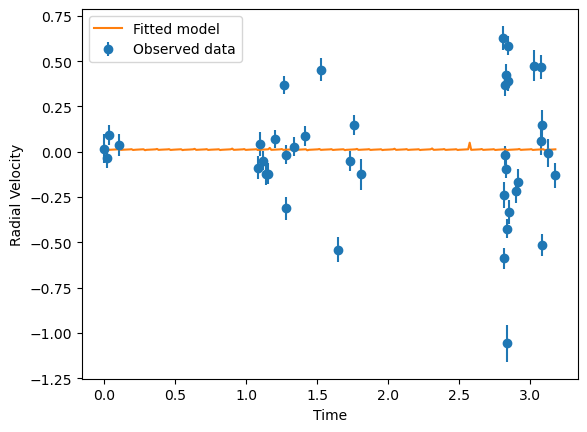

In [759]:
keplar_model = KeplerianOrbitModel(time2, corrected_rv, rv_err)
popt, pcov = keplar_model.fit([0.0095, 1, 1, 0.1, 10, 1])

print(popt)
keplar_model.plot(np.linspace(time2.min(), time2.max(), 301))

In [762]:
x = np.linspace(time.min(), time.max(), 101)
y = np.sin(x)
y_err = np.random.normal(0, 0.01, len(y))

# result = PeriodicKernel(1, 1, 1).fit(time, corrected_rv, rv_err)
result = PeriodicKernel(1, 1, 1).fit(x, y, y_err)


plt.errorbar(time, corrected_rv, yerr=rv_err, fmt='x')

gp = PeriodicKernel(*result.x).compute_kernel(time, time, rv_err).compute_loglikelihood(corrected_rv)
y_pred, y_pred_err = gp.compute_posterior(x)
plt.plot(x, y_pred, 'b')

print(result.x)

LinAlgError: 3-th leading minor of the array is not positive definite

array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01])

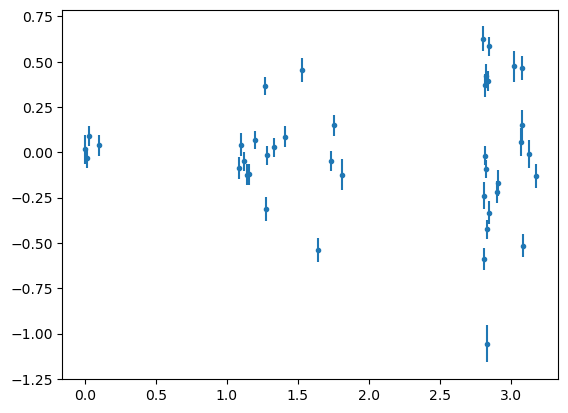

In [752]:
plt.errorbar(time2, corrected_rv, rv_err, fmt='.')
preds = KeplerianOrbitModel(time2, corrected_rv, rv_err)._model(
    np.linspace(time2.min(), time2.max(), 3001),
    0.0095, 1, 1, 0.149, 4.7, 0.01
)

preds

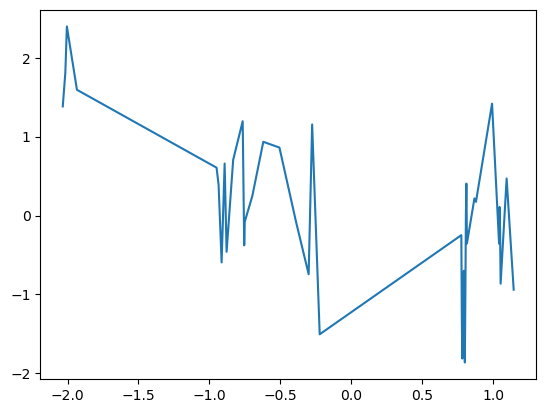

In [682]:
plt.plot(time, rv)

<ErrorbarContainer object of 3 artists>

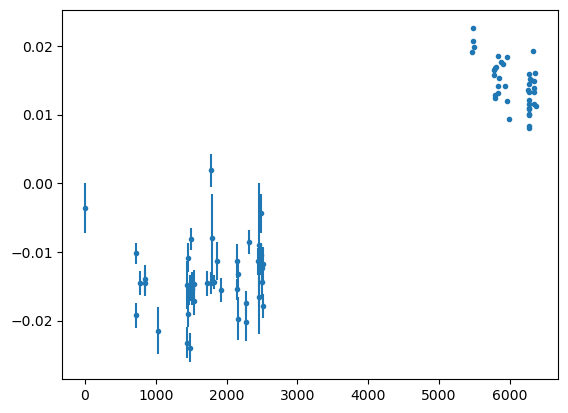

In [671]:
plt.errorbar(data['time'], data['radial_velocity'], data['radial_velocity_uncertainty'], fmt='.')

[-2.59096975e-10  1.96075688e+00  1.89725598e+00] 0.8808443203660943


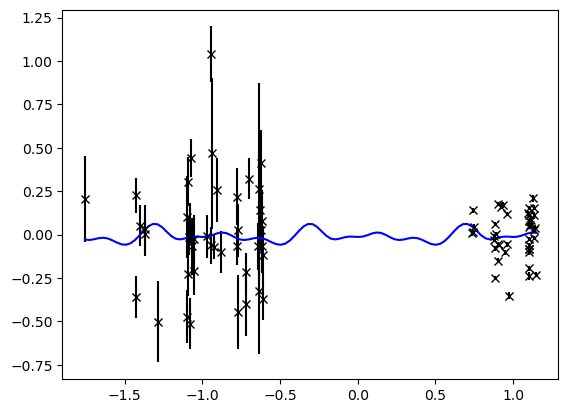

In [638]:
def objective(theta):
    return -PeriodicKernel(*theta).compute_kernel(time, time, rv_err).compute_loglikelihood(corrected_rv).loglikelihood

result = minimize(
    objective, 
    np.array([1, 0.1, 1.2]), 
    method='L-BFGS-B', 
    # bounds=bounds
)

x = np.linspace(time.min(), time.max(), 100)
plt.errorbar(time, corrected_rv, yerr=rv_err, fmt='kx')

gp = PeriodicKernel(1, 1, 1)
result = gp.fit(time, corrected_rv, rv_err)
y_pred, y_pred_err = gp.compute_posterior(x)
plt.plot(x, y_pred, 'b')

print(result.x, gp.loglikelihood)

In [550]:
from scipy.optimize import minimize

# Define the Keplerian equation function for two-dimensional orbits
def keplerian_orbit(t, semi_major_axis, eccentricity, inclination, argument_of_periapsis, longitude_of_ascending_node, true_anomaly):
    # Calculate the position (x, y) in the orbital plane
    # For simplicity, let's assume a simplified model without full Keplerian elements transformation
    M = 2 * np.pi * t / true_anomaly  # Mean anomaly (simplified)
    E = M  # Eccentric anomaly (initial guess for iterative solution)
    
    # Iteratively solve Kepler's equation: E = M + e * sin(E)
    for _ in range(100):
        E = M + eccentricity * np.sin(E)
    
    # True anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + eccentricity) * np.sin(E / 2), np.sqrt(1 - eccentricity) * np.cos(E / 2))
    
    # Distance from the focal point
    r = semi_major_axis * (1 - eccentricity * np.cos(E))
    
    # Position in orbital plane
    x_orbital = r * np.cos(nu)
    y_orbital = r * np.sin(nu)
    
    # Inclination and other transformations could be applied here for 3D orbits
    
    return x_orbital, y_orbital

# Define the cost function
def cost_function(params, t, y, y_errors):
    semi_major_axis, eccentricity, inclination, argument_of_periapsis, longitude_of_ascending_node, true_anomaly = params
    x_pred, y_pred = keplerian_orbit(t, semi_major_axis, eccentricity, inclination, argument_of_periapsis, longitude_of_ascending_node, true_anomaly)
    # Weighted sum of squared residuals only considering y-errors
    cost = np.sum(((y - y_pred) / y_errors) ** 2)
    return cost

In [552]:
# Initial guess for the parameters
initial_guess = [1, 0.1, 0, 0, 0, 10]

# Use scipy.optimize.minimize to find the optimal parameters
result = minimize(cost_function, initial_guess, args=(time, corrected_rv, rv_err))

# Extract the optimal parameters
optimal_params = result.x

print(f"Optimal Parameters: {optimal_params}")

Optimal Parameters: [-21489.36429503  33119.97837944      0.              0.
      0.          -4382.57977339]


/var/folders/13/867mc06s1kz32cp88g91g9gc0000gn/T/ipykernel_98234/1247457735.py:15: RuntimeWarning: invalid value encountered in sqrt
  nu = 2 * np.arctan2(np.sqrt(1 + eccentricity) * np.sin(E / 2), np.sqrt(1 - eccentricity) * np.cos(E / 2))
/var/folders/13/867mc06s1kz32cp88g91g9gc0000gn/T/ipykernel_98234/1247457735.py:15: RuntimeWarning: invalid value encountered in sqrt
  nu = 2 * np.arctan2(np.sqrt(1 + eccentricity) * np.sin(E / 2), np.sqrt(1 - eccentricity) * np.cos(E / 2))
/var/folders/13/867mc06s1kz32cp88g91g9gc0000gn/T/ipykernel_98234/1247457735.py:15: RuntimeWarning: invalid value encountered in sqrt
  nu = 2 * np.arctan2(np.sqrt(1 + eccentricity) * np.sin(E / 2), np.sqrt(1 - eccentricity) * np.cos(E / 2))


In [555]:
import numpy as np

def keplerian_model(t, K, P, e, omega, tp, gamma):
    """
    Keplerian model for radial velocity.

    Parameters:
    t : array_like
        Time array.
    K : float
        Velocity semi-amplitude.
    P : float
        Orbital period.
    e : float
        Eccentricity.
    omega : float
        Argument of periastron.
    tp : float
        Time of periastron passage.
    gamma : float
        Systemic velocity.

    Returns:
    rv : array_like
        Radial velocity at each time.
    """
    M = 2 * np.pi * (t - tp) / P  # Mean anomaly
    E = M + e * np.sin(M)  # Eccentric anomaly (approximation)
    try:
        nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))  # True anomaly
    except:
        print(e)
    
    rv = gamma + K * (np.cos(nu + omega) + e * np.cos(omega))
    return rv

from scipy.optimize import curve_fit

# Initial guesses for the parameters
initial_guess = [10, 365, 0.1, 0, time[0], 0]  # K, P, e, omega, tp, gamma

# Fit the model to the data
popt, pcov = curve_fit(keplerian_model, time, corrected_rv, sigma=rv_err, p0=initial_guess)

# Extract the fitted parameters
K_fit, P_fit, e_fit, omega_fit, tp_fit, gamma_fit = popt


/var/folders/13/867mc06s1kz32cp88g91g9gc0000gn/T/ipykernel_98234/1021025177.py:30: RuntimeWarning: invalid value encountered in sqrt
  nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))  # True anomaly
